In [ ]:
!pip uninstall  -y  socceraction

Found existing installation: socceraction 0.2.0
Uninstalling socceraction-0.2.0:
  Successfully uninstalled socceraction-0.2.0


In [ ]:
!pip install tables==3.6.1
!pip install socceraction
!pip install socceraction[statsbomb]

  Using cached tables-3.6.1.tar.gz (4.6 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tables
  Running setup.py clean for tables
Failed to build tables
ERROR: Could not build wheels for tables, which is required to install pyproject.toml-based projects
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.3/86.3 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 kB 898.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 5.4 MB/s eta 0:00:00


In [ ]:
!pip install fuzzywuzzy

In [ ]:
import pandas as pd
from io import BytesIO
from datetime import timedelta
from datetime import datetime
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import graphviz
from six import StringIO
import pydotplus
from socceraction.spadl.wyscout import convert_to_spadl
import socceraction.vaep.features as features
import socceraction.vaep.labels as labels
from socceraction.vaep.formula import value
from socceraction.data.statsbomb import StatsBombLoader
from tqdm.notebook import tqdm
from xgboost import XGBClassifier
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Pre-processing

In [ ]:
# Function that returns decoded Json files better than panda
def read_json_file(filename):
    with open(filename, 'rb') as json_file:
        return BytesIO(json_file.read()).getvalue().decode('unicode_escape')

In [ ]:
# Reading the Coaches Data
coaches_json = read_json_file('/content/drive/MyDrive/thesis/data/coaches.json')
coaches = pd.read_json(coaches_json)

# Checking for Nulls
coaches.isna().sum()

wyId             0
shortName        0
firstName        0
middleName       0
lastName         0
birthDate        2
birthArea        0
passportArea     0
currentTeamId    0
dtype: int64

Birth day or age of a coach is not an important factor and even if it will be proved to be there is only two missing

In [ ]:
# Visualizing the table to see how the data looks
coaches.head()

,wyId,shortName,firstName,middleName,lastName,birthDate,birthArea,passportArea,currentTeamId
0,275580,Cesar Domingo,César Domingo,,Mendiondo López,None,"{'id': 76, 'alpha2code': 'BR', 'alpha3code': '...","{'id': 76, 'alpha2code': 'BR', 'alpha3code': '...",0
1,14710,J. Heynckes,Josef,,Heynckes,1945-05-09,"{'id': 276, 'alpha2code': 'DE', 'alpha3code': ...","{'id': 276, 'alpha2code': 'DE', 'alpha3code': ...",0
2,135480,G. De Biasi,Giovanni,,De Biasi,1956-06-16,"{'id': 380, 'alpha2code': 'IT', 'alpha3code': ...","{'id': 380, 'alpha2code': 'IT', 'alpha3code': ...",0
3,210074,Marcelino,Marcelino,,García Toral,1965-08-14,"{'id': 724, 'alpha2code': 'ES', 'alpha3code': ...","{'id': 724, 'alpha2code': 'ES', 'alpha3code': ...",674
4,293398,T. Korkut,Tayfun,,Korkut,1974-04-02,"{'id': 276, 'alpha2code': 'DE', 'alpha3code': ...","{'id': 792, 'alpha2code': 'TR', 'alpha3code': ...",0


In [ ]:
# Reading the teams data
teams_json = read_json_file('/content/drive/MyDrive/thesis/data/teams.json')
teams = pd.read_json(teams_json)

# Checking for Nulls
teams.isna().sum()

city            0
name            0
wyId            0
officialName    0
area            0
type            0
dtype: int64

In [ ]:
# Visualizing the table to see how the data looks
teams.head()

,city,name,wyId,officialName,area,type
0,Newcastle upon Tyne,Newcastle United,1613,Newcastle United FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
1,Vigo,Celta de Vigo,692,Real Club Celta de Vigo,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
2,Barcelona,Espanyol,691,Reial Club Deportiu Espanyol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,Vitoria-Gasteiz,Deportivo Alavés,696,Deportivo Alavés,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
4,Valencia,Levante,695,Levante UD,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club


In [ ]:
# Reading the players data
player_json = read_json_file('/content/drive/MyDrive/thesis/data/players.json')
players = pd.read_json(player_json)

# Checking for Nulls
players.isna().sum()

passportArea              0
weight                    0
firstName                 0
middleName                0
lastName                  0
currentTeamId            91
birthDate                 0
height                    0
role                      0
birthArea                 0
wyId                      0
foot                      0
shortName                 0
currentNationalTeamId     0
dtype: int64

With investigation it wa found these null values correspond to players that did not play that season and therefore have a ull team ID value and national team id as well

In [ ]:
# Visualizing the table to see how the data looks
players.head()

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
0,"{'name': 'Turkey', 'id': '792', 'alpha3code': ...",78,Harun,,Tekin,4502,1989-06-17,187,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Turkey', 'id': '792', 'alpha3code': ...",32777,right,H. Tekin,4687
1,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",73,Malang,,Sarr,3775,1999-01-23,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393228,left,M. Sarr,4423
2,"{'name': 'France', 'id': '250', 'alpha3code': ...",72,Over,,Mandanda,3772,1998-10-26,176,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'France', 'id': '250', 'alpha3code': ...",393230,,O. Mandanda,null
3,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",82,Alfred John Momar,,N'Diaye,683,1990-03-06,187,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'France', 'id': '250', 'alpha3code': ...",32793,right,A. N'Diaye,19314
4,"{'name': 'France', 'id': '250', 'alpha3code': ...",84,Ibrahima,,Konaté,2975,1999-05-25,192,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393247,right,I. Konaté,null


In [ ]:
# Reading the Premier league matches data
matches_json = read_json_file('/content/drive/MyDrive/thesis/data/matches_Germany.json')
matches = pd.read_json(matches_json)

# Checking for Nulls
matches.isna().sum()

status           0
roundId          0
gameweek         0
teamsData        0
seasonId         0
dateutc          0
winner           0
venue            0
wyId             0
label            0
date             0
referees         0
duration         0
competitionId    0
dtype: int64

In [ ]:
# Visualizing the table to see how the data looks
matches.head()

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,referees,duration,competitionId
0,Played,4405517,34,"{'2444': {'scoreET': 0, 'coachId': 14710, 'sid...",181137,2018-05-12 13:30:00,2445,Allianz Arena,2517036,"Bayern München - Stuttgart, 1 - 4","May 12, 2018 at 3:30:00 PM GMT+2","[{'refereeId': 379444, 'role': 'referee'}, {'r...",Regular,426
1,Played,4405517,34,"{'2482': {'scoreET': 0, 'coachId': 272299, 'si...",181137,2018-05-12 13:30:00,2482,WIRSOL Rhein-Neckar-Arena,2517037,"Hoffenheim - Borussia Dortmund, 3 - 1","May 12, 2018 at 3:30:00 PM GMT+2","[{'refereeId': 384936, 'role': 'referee'}, {'r...",Regular,426
2,Played,4405517,34,"{'2457': {'scoreET': 0, 'coachId': 18987, 'sid...",181137,2018-05-12 13:30:00,2975,Olympiastadion Berlin,2517038,"Hertha BSC - RB Leipzig, 2 - 6","May 12, 2018 at 3:30:00 PM GMT+2","[{'refereeId': 387276, 'role': 'referee'}, {'r...",Regular,426
3,Played,4405517,34,"{'2453': {'scoreET': 0, 'coachId': 14977, 'sid...",181137,2018-05-12 13:30:00,2453,Schwarzwald-Stadion,2517039,"Freiburg - Augsburg, 2 - 0","May 12, 2018 at 3:30:00 PM GMT+2","[{'refereeId': 378957, 'role': 'referee'}, {'r...",Regular,426
4,Played,4405517,34,"{'2449': {'scoreET': 0, 'coachId': 447924, 'si...",181137,2018-05-12 13:30:00,2449,VELTINS-Arena,2517040,"Schalke 04 - Eintracht Frankfurt, 1 - 0","May 12, 2018 at 3:30:00 PM GMT+2","[{'refereeId': 387273, 'role': 'referee'}, {'r...",Regular,426


In [ ]:
# Reading the Bundesliga events data
BL_json = read_json_file('/content/drive/MyDrive/thesis/data/events_Germany.json')
BL = pd.read_json(BL_json)

# Checking for Nulls
BL.isna().sum()

eventId         0
subEventName    0
tags            0
playerId        0
positions       0
matchId         0
eventName       0
teamId          0
matchPeriod     0
eventSec        0
subEventId      0
id              0
dtype: int64

In [ ]:
# Visualizing the table to see how the data looks
BL.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],15231,"[{'y': 50, 'x': 50}, {'y': 48, 'x': 50}]",2516739,Pass,2446,1H,2.409746,85,179896442
1,8,Simple pass,[{'id': 1801}],14786,"[{'y': 48, 'x': 50}, {'y': 22, 'x': 22}]",2516739,Pass,2446,1H,2.506082,85,179896443
2,8,Simple pass,[{'id': 1801}],14803,"[{'y': 22, 'x': 22}, {'y': 46, 'x': 6}]",2516739,Pass,2446,1H,6.946706,85,179896444
3,8,Simple pass,[{'id': 1801}],14768,"[{'y': 46, 'x': 6}, {'y': 10, 'x': 20}]",2516739,Pass,2446,1H,10.786491,85,179896445
4,8,Simple pass,[{'id': 1801}],14803,"[{'y': 10, 'x': 20}, {'y': 4, 'x': 27}]",2516739,Pass,2446,1H,12.684514,85,179896446


# Question 1: How do different measures of similarity between event sequences relate to a football team’s performance? And which of them is most important in predicting success?

## Sequence Analysis

In [ ]:
# Adding a row that will help in determining the end of a sequence
BL['sequence_analysis'] = BL['teamId'].shift(1)
print(BL[BL.eventName=='Foul'].subEventName.unique())
# Dropping any event that saved as Foul as this is irrelevant to the data as it just describes the type of foul given to the event before it
BL = BL.drop(BL[BL.eventName=='Foul'].index)

['Foul' 'Hand foul' 'Time lost foul' 'Out of game foul' 'Simulation'
 'Late card foul' 'Protest' 'Violent Foul']


In [ ]:
seq = 0
top_5 = ['Bayern München','Hoffenheim','Borussia Dortmund','Schalke 04','Bayer Leverkusen']
top_middle = ['RB Leipzig', 'Eintracht Frankfurt', "Borussia M'gladbach",'Stuttgart','Hertha BSC']
bottom_middle = ['Hannover 96','Augsburg','Werder Bremen','Mainz 05','Freiburg']
# Creating a Column stating whether the team is playing home or away
def team_side(row):
  teams_data = matches[matches['wyId']==row.matchId].iloc[0]['teamsData']
  side = teams_data[str(row.teamId)]['side']
  return side

# Creating a Column Stating the team's Name
def team_name(row):
    name = teams[teams['wyId']==row.teamId].iloc[0]['name'].encode().decode('unicode-escape')
    return name

# Creating a column stating y position
def start_y(row):
  position = row.positions[0]['y']
  return position

# Creating a column ending y position
def end_y(row):
  position = row.positions[1]['y']
  return position

# Creating a column stating x position
def start_x(row):
  position = row.positions[0]['x']
  return position

# Creating a column ending x position
def end_x(row):
  position = row.positions[1]['x']
  return position

# Creating a timestamp column
def timestamp(row):
    time = matches[matches['wyId']==row.matchId].iloc[0]['dateutc'].split()
    start_time = datetime.strptime(time[1],'%H:%M:%S')
    start_time_sec = start_time.second + start_time.minute*60 + start_time.hour*3600
    if row.matchPeriod=='2H':
      time_stamp = time[0] + 'T' + str(timedelta(seconds=row.eventSec + 3600 + start_time_sec))
    else:
      time_stamp = time[0] + 'T' + str(timedelta(seconds=row.eventSec + start_time_sec))
    return time_stamp

# Grouping events into sequence
def sequence_groups(row):
  global seq
  if row.sequence_analysis==row.teamId:
    sequence = seq
  else:
    seq+=1
    sequence = seq
  return sequence

# Creating a Column of Match Rank
def type_of_match(row):
  teams_data = matches[matches['wyId']==row.matchId].iloc[0]['teamsData']
  teams_in_match = list(teams_data.keys())
  teams_in_match.remove(str(row.teamId))
  against = int(teams_in_match[0])
  teams_in_play = [row.teamId, against]
  team_rank = []
  for i in teams_in_play:
    name = teams[teams['wyId']==i].iloc[0]['name']
    if name in top_5:
      team_rank.append('Top 5')
    elif name in top_middle:
      team_rank.append('Top Middle 5')
    elif name in bottom_middle:
      team_rank.append('Bottom Middle 5')
    else:
      team_rank.append('Bottom 5')

  match_rank = ' vs '.join(team_rank)
  return match_rank

# Calculating the Columns
BL['Side'] = BL.apply(team_side,axis=1)
BL['Name'] = BL.apply(team_name,axis=1)
BL['start_y'] = BL.apply(start_y,axis=1)
BL['end_y'] = BL.apply(end_y,axis=1)
BL['start_x'] = BL.apply(start_x,axis=1)
BL['end_x'] = BL.apply(end_x,axis=1)
BL['Timestamp'] = BL.apply(timestamp,axis=1)
BL['Sequence'] = BL.apply(sequence_groups,axis=1)
BL['Match Rank'] = BL.apply(type_of_match,axis=1)

In [ ]:
# Removing all Sequences that are shorter than 3 Events
BL = BL[BL.groupby('Sequence').Sequence.transform('count') > 2]

# Selecting last event in each sequece to analyze whether it was a sucessful sequence or not
end_event = BL.groupby('Sequence').last()

# Understanding how can a sequence end by displaying all possible end
for i in end_event.eventName.unique():
  print(i)
  df = end_event[(end_event['eventName']==i)]
  print(df.subEventName.unique())

Pass
['Simple pass' 'Head pass' 'Cross' 'Smart pass' 'Launch' 'High pass'
 'Hand pass']
Duel
['Ground attacking duel' 'Air duel' 'Ground defending duel'
 'Ground loose ball duel']
Shot
['Shot']
Interruption
['Ball out of the field' 'Whistle']
Others on the ball
['Touch' 'Acceleration' 'Clearance']
Free Kick
['Throw in' 'Corner' 'Goal kick' 'Free Kick']
Offside
['']
Goalkeeper leaving line
['Goalkeeper leaving line']
Save attempt
['Reflexes' 'Save attempt']


In [ ]:
# Dividing sequences number into sucessful or not
successful_seq = []
un_seq = []
for index , row in end_event.iterrows():
  if row.eventName == 'Shot' or row.eventName == 'Goalkeeper leaving line':
    successful_seq.append(index)
  elif (row.eventName == 'Pass' or row.eventName == 'Duel' or row.eventName == 'Others on the ball') and row.end_x>75:
    successful_seq.append(index)
  elif (row.subEventName == 'Corner' or row.subEventName == 'Free Kick'):
    successful_seq.append(index)
  else:
    un_seq.append(index)

In [ ]:
# Setting all events in a sequence to 1 if found successful in the above analysis and 0 if unsuccessful
def sucessful_seq(row):
  if row.Sequence in successful_seq:
    return 1
  elif row.Sequence in un_seq:
    return 0
BL['Successful'] = BL.apply(sucessful_seq,axis=1)

In [ ]:
# Selecting the relevant rows for analysis
BL_analyis = BL[['Sequence', 'eventName','subEventName','playerId','matchId','Timestamp','matchPeriod','start_y','end_y','start_x','end_x','Name','Side','Match Rank','Successful']]

In [ ]:
# For process mining it is required that all sequences begin with the same thing so adding In at the beginning
def add_row_at_beginning(x):
  data = []
  first_row = x.iloc[0]
  first_row['eventName'] = 'In'
  first_rows = dict(first_row)
  data.insert(0,first_rows)
  return pd.concat([pd.DataFrame(data), x], ignore_index=True)
BL_analyis = BL_analyis.groupby('Sequence').apply(add_row_at_beginning).reset_index(drop=True)

# For process mining it is required that all sequences end with the same thing so adding Out at the end
def add_row_at_end(x):
  last_row = x.iloc[-1]
  last_row['eventName'] = 'Out'
  return x.append(last_row)
BL_analyis = BL_analyis.groupby('Sequence').apply(add_row_at_end).reset_index(drop=True)

Streaming output truncated to the last 5000 lines.
<ipython-input-26-ff9f87275646>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return x.append(last_row)
<ipython-input-26-ff9f87275646>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return x.append(last_row)
<ipython-input-26-ff9f87275646>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return x.append(last_row)
<ipython-input-26-ff9f87275646>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return x.append(last_row)
<ipython-input-26-ff9f87275646>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

In [ ]:
# Displaying the final table
BL_analyis.head(20)

,Sequence,eventName,playerId,matchId,Timestamp,matchPeriod,start_y,end_y,start_x,end_x,Name,Side,Match Rank,Successful
0,1,In,15231,2516739,2017-08-18T18:30:02.409746,1H,50,48,50,50,Bayer Leverkusen,away,Top 5 vs Bottom 5,0
1,1,Pass,15231,2516739,2017-08-18T18:30:02.409746,1H,50,48,50,50,Bayer Leverkusen,away,Top 5 vs Bottom 5,0
2,1,Pass,14786,2516739,2017-08-18T18:30:02.506082,1H,48,22,50,22,Bayer Leverkusen,away,Top 5 vs Bottom 5,0
3,1,Pass,14803,2516739,2017-08-18T18:30:06.946706,1H,22,46,22,6,Bayer Leverkusen,away,Top 5 vs Bottom 5,0
4,1,Pass,14768,2516739,2017-08-18T18:30:10.786491,1H,46,10,6,20,Bayer Leverkusen,away,Top 5 vs Bottom 5,0
5,1,Pass,14803,2516739,2017-08-18T18:30:12.684514,1H,10,4,20,27,Bayer Leverkusen,away,Top 5 vs Bottom 5,0
6,1,Pass,40657,2516739,2017-08-18T18:30:15.530516,1H,4,1,27,18,Bayer Leverkusen,away,Top 5 vs Bottom 5,0
7,1,Pass,14803,2516739,2017-08-18T18:30:17.507003,1H,1,1,18,28,Bayer Leverkusen,away,Top 5 vs Bottom 5,0
8,1,Pass,40657,2516739,2017-08-18T18:30:18.404516,1H,1,20,28,30,Bayer Leverkusen,away,Top 5 vs Bottom 5,0
9,1,Out,40657,2516739,2017-08-18T18:30:18.404516,1H,1,20,28,30,Bayer Leverkusen,away,Top 5 vs Bottom 5,0


In [ ]:
BL_analyis['Match Rank'].nunique()

16

In [ ]:
os.mkdir('/content/drive/MyDrive/thesis/Bundesliga/Match Rank')
match_rank = BL_analyis['Match Rank'].unique()
success = BL_analyis['Successful'].unique()
for i in match_rank:
  df  = BL_analyis[BL_analyis['Match Rank']== i]
  for num in success:
    sub_df = df[df['Successful']==num]
    if num==1:
      path = '/content/drive/MyDrive/thesis/Bundesliga/Match Rank/'+ i+' Success.csv'
    else:
      path = '/content/drive/MyDrive/thesis/Bundesliga/Match Rank/'+ i+' Unsuccess.csv'
    sub_df.to_csv(path,index=False)

In [ ]:
teams = BL_analyis.Name.unique()
success = BL_analyis.Successful.unique()
sides = BL_analyis.Side.unique()
for team in teams:
  path  = '/content/drive/MyDrive/thesis/Bundesliga/'+ team
  team_events = BL_analyis[BL_analyis['Name']== team]
  os.mkdir(path)
  for side in sides:
    sub_path = path +'/' + team +' ' + side
    side_team_events =  team_events[team_events['Side']==side]
    for num in success:
      sub_df = side_team_events[side_team_events['Successful']==num]
      if num==1:
        final_path = sub_path +' Success.csv'
      else:
        final_path = sub_path +' Unsuccess.csv'
      sub_df.to_csv(final_path,index=False)

## Success Reason Analysis

In [ ]:
# Function to count number of passes
def number_of_passes(x):
  passes = x[x['eventName']=='Pass']
  return len(passes)

# function to calculate total time of a sequence
def deta_time(x):
  try:
    first_event_time = x.iloc[0].split('T')[1]
    first_event_time = datetime.strptime(first_event_time, "%H:%M:%S.%f")
  except:
    first_event_time = x.iloc[0].split('T')[1]
    first_event_time = datetime.strptime(first_event_time, "%H:%M:%S")
  try:
    last_event_time = x.iloc[-1].split('T')[1]
    last_event_time = datetime.strptime(last_event_time, "%H:%M:%S.%f")
  except:
    last_event_time = x.iloc[-1].split('T')[1]
    last_event_time = datetime.strptime(last_event_time, "%H:%M:%S")
  return (last_event_time-first_event_time).total_seconds()

# Calculating the total distance covered from start point till end point
def total_distance_covered(x):
  start_x = x['start_x'].iloc[0]
  end_x = x['end_x'].iloc[-2]
  start_y = x['start_y'].iloc[0]
  end_y = x['end_y'].iloc[-2]
  total_distance = math.sqrt(((start_x-end_x)**2)+((start_y-end_y)**2))
  return total_distance

# Total upfield distance
def upfield_distance_covered(x):
  start = x['start_x'].iloc[0]
  end_x = x['end_x'].iloc[-1]
  if end_x ==0:
    if x['eventName'].iloc[-1]=='Shot':
      end = 100
    else:
      end = x['start_x'].iloc[-1]
  else:
    end = end_x
  return end-start

# Average event distance per sequence
def average_distance(x):
  sequence_distance = 0
  for i in range(len(x)):
    start_x =  x['start_x'].iloc[i]
    end_x = x['end_x'].iloc[i]
    start_y =  x['start_y'].iloc[i]
    end_y = x['end_y'].iloc[i]
    event_distance = math.sqrt(((start_x-end_x)**2)+((start_y-end_y)**2))
    sequence_distance += event_distance
  return sequence_distance/len(x)

# Number of each type of pass per Sequence
def type_pass(x):
  different_passes = dict(x.subEventName.value_counts())
# Count Simple Pass
  try:
    simple = different_passes['Simple pass']
  except:
    simple = 0
# Count High Pass
  try:
    high = different_passes['High pass']
  except:
    high = 0
# Count Head Pass
  try:
    head = different_passes['Head pass']
  except:
    head = 0
# Count Crosses
  try:
    cross = different_passes['Cross']
  except:
    cross = 0
# Count Hand Pass
  try:
    hand = different_passes['Hand pass']
  except:
    hand = 0
# Count Smart Pass
  try:
    smart = different_passes['Smart pass']
  except:
    smart = 0
# Count Launches
  try:
    launch = different_passes['Launch']
  except:
    launch = 0
  passes_list = []
  passes_list.append(simple)
  passes_list.append(high)
  passes_list.append(head)
  passes_list.append(cross)
  passes_list.append(hand)
  passes_list.append(smart)
  passes_list.append(launch)
  return passes_list

#Function to count Number of passes mae to different areas of the field
def passes_in_different_areas(x):
  passes = x[x['eventName']=='Pass']
  area_1 = 0
  area_2 = 0
  area_3 = 0
  area_4 = 0
  area_5 = 0
  area_6 = 0
  area_7 = 0
  area_8 = 0
  area_9 = 0
  area_10 = 0
  for i in range(len(passes)):
    if passes['end_x'].iloc[i]<=50:
      area_1 += 1
    elif passes['end_x'].iloc[i]<=67:
      if passes['end_y'].iloc[i]<=19:
        area_2 += 1
      elif passes['end_y'].iloc[i]<=81:
        area_3 += 1
      else:
        area_4 += 1
    elif passes['end_x'].iloc[i]<=84:
      if passes['end_y'].iloc[i]<=19:
        area_5 += 1
      elif passes['end_y'].iloc[i]<=81:
        area_6 += 1
      else:
        area_7 += 1
    elif passes['end_x'].iloc[i]>84:
      if passes['end_y'].iloc[i]<=19:
        area_8 += 1
      elif passes['end_y'].iloc[i]<=81:
        area_9 += 1
      else:
        area_10 += 1
  area_passes = []
  area_passes.append(area_1)
  area_passes.append(area_2)
  area_passes.append(area_3)
  area_passes.append(area_4)
  area_passes.append(area_5)
  area_passes.append(area_6)
  area_passes.append(area_7)
  area_passes.append(area_8)
  area_passes.append(area_9)
  area_passes.append(area_10)
  return area_passes

In [ ]:
# Creating new Dataframe with Sequence number as its first column but now only 1 row per sequence
perform = pd.DataFrame(BL_analyis.Sequence.unique(),columns=['Sequence'])

# The first event of each Sequence
first_event = list(BL_analyis.groupby(['Sequence'])['eventName'].first())
perform['First Event'] = first_event

# The half the sequence occurred in
match_period = list(BL_analyis.groupby(['Sequence'])['matchPeriod'].first())
perform['Match Period'] = match_period

# The Team name
name = list(BL_analyis.groupby(['Sequence'])['Name'].first())
perform['Name'] = name

# Home or Away
side = list(BL_analyis.groupby(['Sequence'])['Side'].first())
perform['Side'] = side

# Overall time of the Sequence
time = list(BL_analyis.groupby('Sequence')['Timestamp'].apply(deta_time))
perform['Sequence Time'] = time

#Total Distance covered from start point to end point
distance_covered = list(BL_analyis.groupby('Sequence').apply(total_distance_covered))
perform['Distance Covered'] = distance_covered

# Total Distance Upfield (X-axis)
upfield_distance = list(BL_analyis.groupby('Sequence').apply(upfield_distance_covered))
perform ['Upfield Distance']= upfield_distance

# Speed to bring the ball upfield
perform['Speed'] = perform ['Upfield Distance'] / perform['Sequence Time']

# Average Distance per event in the sequence
average_distance = list(BL_analyis.groupby('Sequence').apply(average_distance))
perform['Average Distance'] = average_distance

# Number of each type of pass in a sequence
passes_list = list(BL_analyis.groupby('Sequence').apply(type_pass))
passes_df = pd.DataFrame(passes_list,columns = ['Simple Pass', 'High Pass', 'Head Pass', 'Cross', 'Hand Pass','Smart Pass','Launch'])
perform = pd.concat([perform, passes_df], axis="columns")

# Counting the number of Passes in the Sequence
passes = list(BL_analyis.groupby('Sequence').apply(number_of_passes))
perform['Num of Passes'] = passes

# Number of Passes to dfferent areas of the field
area_passes= list(BL_analyis.groupby('Sequence').apply(passes_in_different_areas))
area_df = pd.DataFrame(area_passes,columns = ['Area 1', 'Area 2', 'Area 3', 'Area 4', 'Area 5', 'Area 6', 'Area 7', 'Area 8', 'Area 9', 'Area 10'])
perform = pd.concat([perform, area_df], axis="columns")

# The Sequence is successful or not
success = list(BL_analyis.groupby(['Sequence'])['Successful'].first())
perform['Successful'] = success
perform.head()

,Sequence,First Event,Match Period,Name,Side,Sequence Time,Distance Covered,Upfield Distance,Speed,Average Distance,...,Area 2,Area 3,Area 4,Area 5,Area 6,Area 7,Area 8,Area 9,Area 10,Successful
0,1,Pass,1H,Bayer Leverkusen,away,15.994770,53.712196,-20,-1.250409,19.436515,...,0,0,0,0,0,0,0,0,0,0
1,2,Pass,1H,Bayern München,home,2.709763,6.082763,5,1.845180,10.903926,...,0,0,0,0,1,2,0,0,0,0
2,7,Duel,1H,Bayer Leverkusen,away,6.509251,40.049969,56,8.603140,22.320357,...,0,0,0,0,1,0,0,1,0,1
3,12,Pass,1H,Bayern München,home,18.065493,22.135944,24,1.328500,43.284821,...,1,0,0,0,0,0,0,0,0,0
4,14,Duel,1H,Bayern München,home,15.943036,65.215029,54,3.387059,27.563002,...,0,0,0,1,1,0,1,1,0,1


In [ ]:
# Analyzing the team style of play
team_style = perform[['Name','Speed','Num of Passes']]
team_style.replace([np.inf, -np.inf], np.nan, inplace=True)
team_style.dropna(inplace = True)
team_style_grouped = team_style.groupby(['Name']).mean()
team_style_grouped.head(20)
rank = []
for index, row in team_style_grouped.iterrows():
  if index in top_5:
    rank.append('Top 5')
  elif index in top_middle:
    rank.append('Top Middle 5')
  elif index in bottom_middle:
    rank.append('Bottom Middle 5')
  else:
    rank.append('Bottom 5')
team_style_grouped['Rank'] = rank
team_style_grouped.head(20)

<ipython-input-21-76ef5b463e9b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_style.replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-21-76ef5b463e9b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_style.dropna(inplace = True)


,Speed,Num of Passes,Rank
Name,,,
Augsburg,3.242177,3.014911,Bottom Middle 5
Bayer Leverkusen,2.856935,4.076832,Top 5
Bayern München,2.171767,5.468062,Top 5
Borussia Dortmund,2.771971,4.966762,Top 5
Borussia M'gladbach,2.798995,4.244992,Top Middle 5
Eintracht Frankfurt,3.005202,3.407168,Top Middle 5
Freiburg,2.839056,3.413240,Bottom Middle 5
Hamburger SV,3.184761,3.040588,Bottom 5
Hannover 96,3.090117,3.142124,Bottom Middle 5


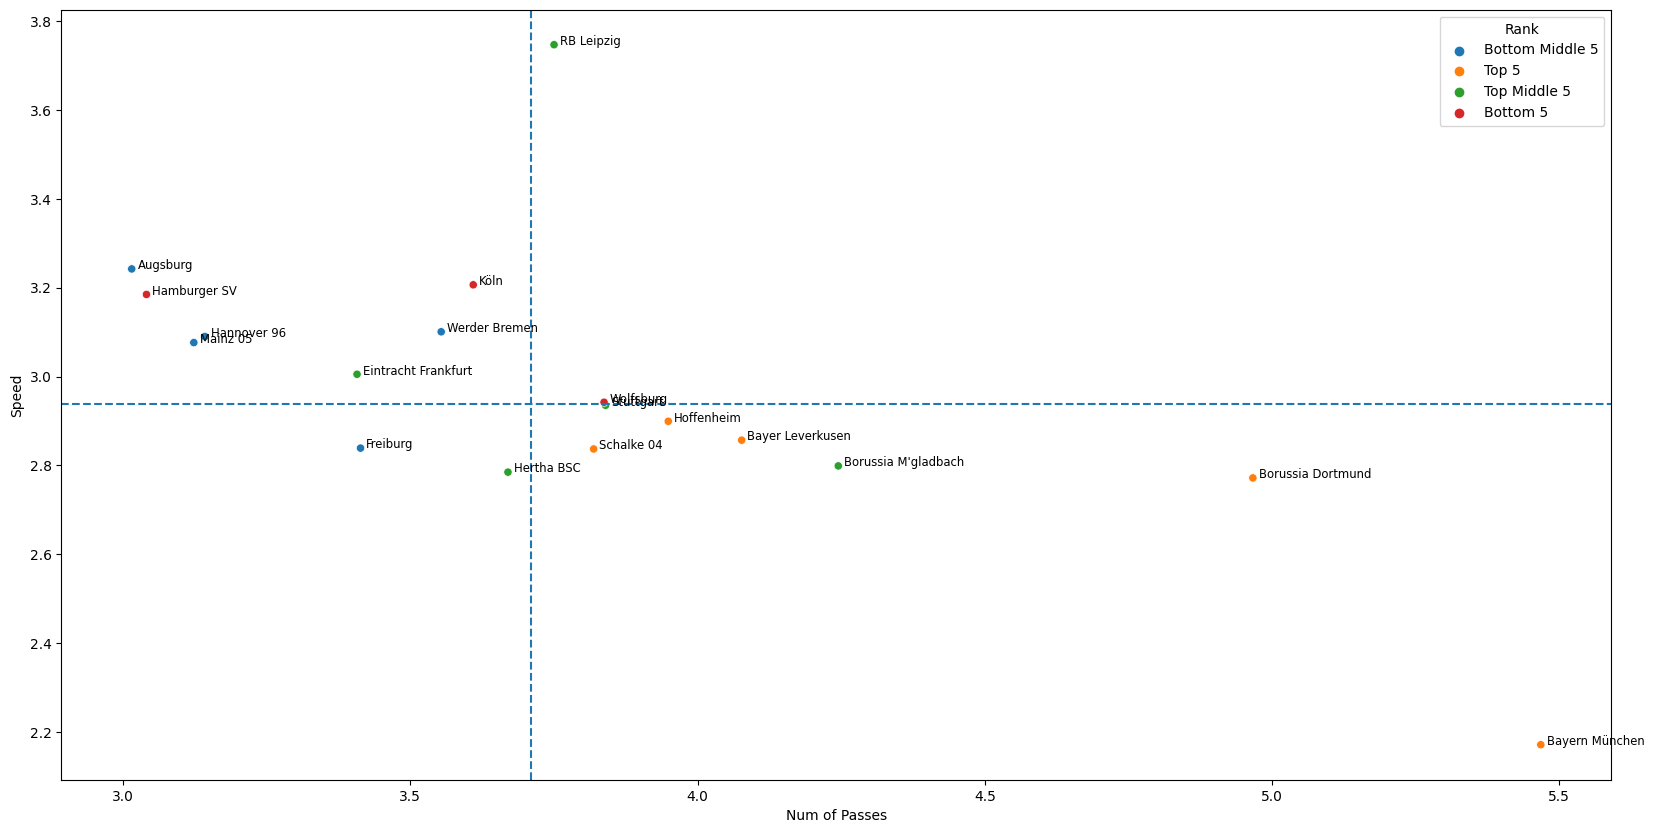

In [ ]:
# Visualizing that style
speed_med = team_style_grouped['Speed'].median()
pass_med = team_style_grouped['Num of Passes'].median()
ax = plt.figure(figsize=(20,10))
plt1 = sns.scatterplot(data = team_style_grouped, x='Num of Passes', y='Speed',hue = 'Rank')
plt1.axvline(x = pass_med, ymin = 0, ymax = 1,linestyle = "dashed")
plt1.axhline(y = speed_med, xmin = 0, xmax = 1,linestyle = "dashed")
for line in range(0,team_style_grouped.shape[0]):
     plt1.text(team_style_grouped['Num of Passes'][line]+0.01, team_style_grouped.Speed[line],
     team_style_grouped.index[line], horizontalalignment='left',
     size='small')

In [ ]:
# Encoding the Categorical columns
need_encode = ['First Event','Match Period','Side']
encoded_order = []
perform_encoded = perform.copy()
for i in need_encode:
  data = perform[i]
  le = LabelEncoder()
  le.fit(data)
  encoded_order.append(le.classes_)
  encoded_data = le.transform(data)
  perform_encoded[i] = encoded_data
perform_encoded.replace([np.inf, -np.inf], np.nan, inplace=True)
perform_encoded.dropna(inplace=True)

In [ ]:
# Displaying the enocded order of each column
for i in encoded_order:
  print(i)

['Duel' 'Free Kick' 'Goalkeeper leaving line' 'Interruption'
 'Others on the ball' 'Pass' 'Save attempt' 'Shot']
['1H' '2H']
['away' 'home']


In [ ]:
# Dividing the data in train and test subsets
y = perform_encoded.Successful
X = perform_encoded.drop(['Successful','Sequence','Name'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Training the first model
cdt = tree.DecisionTreeClassifier()
cdt.fit(X_train, y_train)
y_pred = cdt.predict(X_test)
accuracy_score(y_test,y_pred)

0.8029808625099215

In [ ]:
# Extracting the alphas to prune the tree to reduce complexcity
alphas = cdt.cost_complexity_pruning_path(X_train, y_train)['ccp_alphas']

In [ ]:
# Getting the best alpha that prunes that tree without sacrificing the accuracy
param_grid = [{
    'ccp_alpha': alphas}]
dt = tree.DecisionTreeClassifier()
grid_search = GridSearchCV(dt, param_grid,scoring='accuracy',cv=3)
grid_search.fit(X_train,y_train)
best_parameters = grid_search.best_params_
score = grid_search.best_score_

In [ ]:
# Displaying the best parameters with its score
print(best_parameters)
print(score)

{'ccp_alpha': 0.0002003612274987217}
0.83711081048325


In [ ]:
# Extracting the best model and testing it with test subset
best_cdt = grid_search.best_estimator_
y_pred = best_cdt.predict(X_test)
accuracy_score(y_test,y_pred)

0.8333186348002469

In [ ]:
# Saving the Tree
features = [u'{}'.format(c) for c in X_train.columns]
classes = [u'{}'.format(c) for c in best_cdt.classes_]
dot_data = StringIO()
tree.export_graphviz(best_cdt, out_file=dot_data,
                                feature_names=features,
                                class_names=classes,
                                filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('/content/drive/MyDrive/thesis/Bundesliga/Bundesliga_DT.png')

True

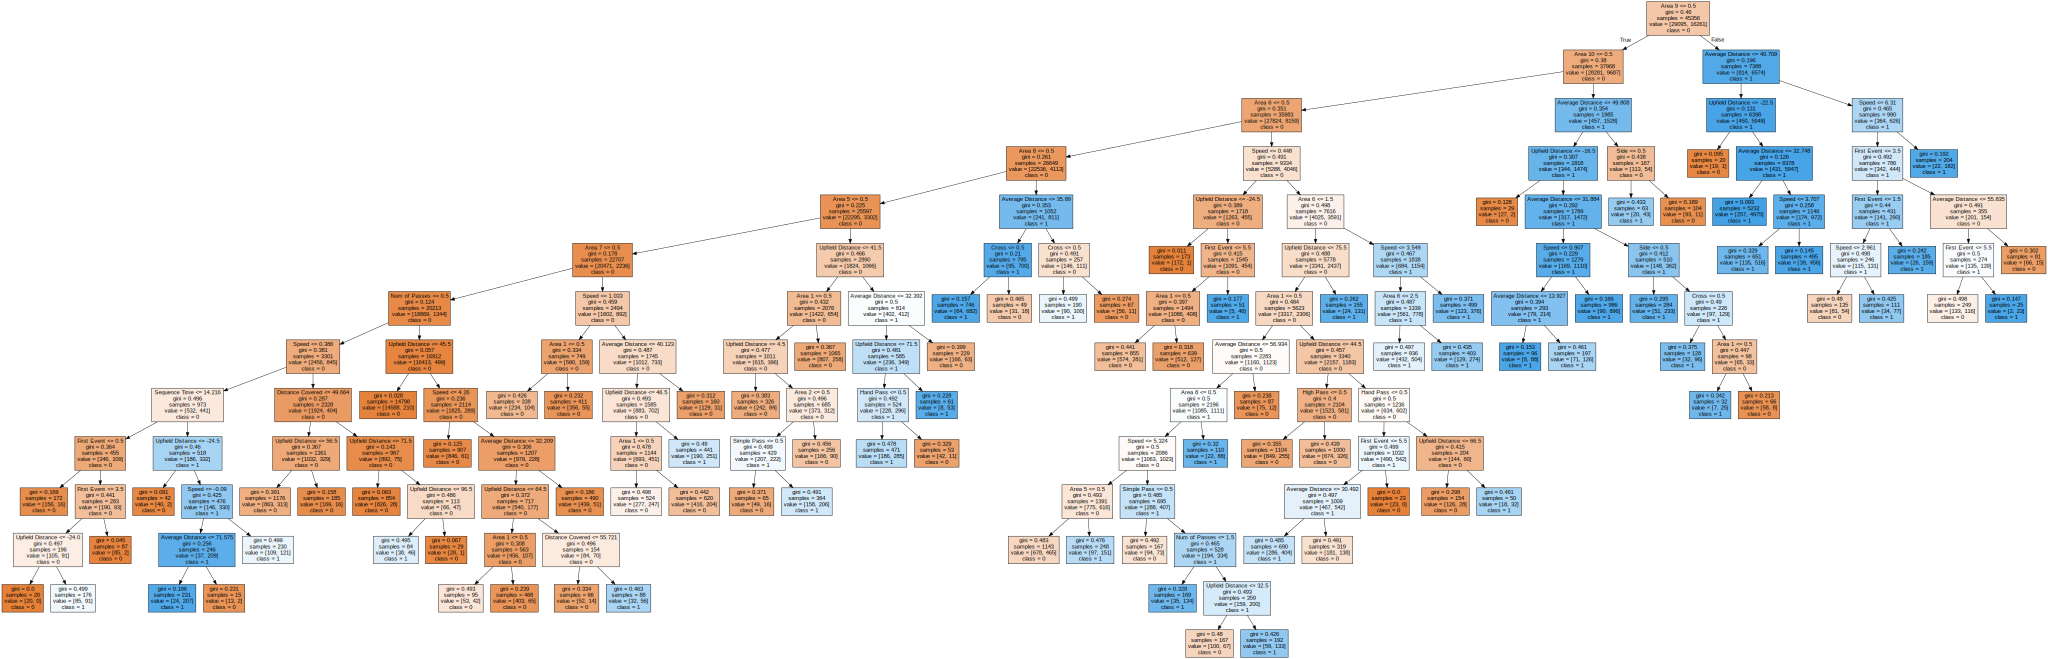

In [ ]:
# Visulaizing the Tree
features = [u'{}'.format(c) for c in X_train.columns]
classes = [u'{}'.format(c) for c in best_cdt.classes_]
dot_data = tree.export_graphviz(best_cdt, out_file=None,
                                feature_names=features,
                                class_names=classes,
                                filled=True)
graph = graphviz.Source(dot_data, format="png")
graph

# Question 2:	How can event sequence analysis identify the key players and positions that contribute most to a team's success in football, and what insights can be gained from this analysis?

In [ ]:
# Transforming the teams data to H5 format
teams.to_hdf('BL.h5', key='teams', mode='w')

# Transforming the players data to H5 format
players.to_hdf('BL.h5', key='players', mode='a')

# Transforming the matches data to H5 format
matches.to_hdf('BL.h5', key='matches', mode='a')

# Transforming the event data to H5 format grouped per
events_grouped_per_match = BL.groupby('matchId', as_index=False)
for id, events_per_match in events_grouped_per_match:
  events_per_match.to_hdf('BL.h5', key=f'events/match_{id}', mode='a')

# Converting the above data to SPAL format
convert_to_spadl('BL.h5', 'spadl.h5')

<ipython-input-19-5e0da8e981c7>:2: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['city', 'name', 'officialName', 'area', 'type'], dtype='object')]

  teams.to_hdf('BL.h5', key='teams', mode='w')
<ipython-input-19-5e0da8e981c7>:5: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['passportArea', 'firstName', 'middleName', 'lastName', 'currentTeamId',
       'birthDate', 'role', 'birthArea', 'foot', 'shortName',
       'currentNationalTeamId'],
      dtype='object')]

  players.to_hdf('BL.h5', key='players', mode='a')
<ipython-input-19-5e0da8e981c7>:8: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] 

...Inserting actiontypes
...Inserting bodyparts
...Inserting results
...Converting games
...Converting players
...Converting teams
...Generating player_games


100%|██████████| 306/306 [00:41<00:00,  7.38game/s]


...Converting events to actions


100%|██████████| 306/306 [04:10<00:00,  1.22game/s]


In [ ]:
# Reading the required datasets from the SPAL format
games = pd.read_hdf('spadl.h5', key='games')
action_types = pd.read_hdf('spadl.h5', key='actiontypes')
body_parts = pd.read_hdf('spadl.h5', key='bodyparts')
results = pd.read_hdf('spadl.h5', key='results')

In [ ]:
# Grouping all the necessary feature generators
functions_features = [
    features.actiontype_onehot,
    features.bodypart_onehot,
    features.result_onehot,
    features.goalscore,
    features.startlocation,
    features.endlocation,
    features.movement,
    features.space_delta,
    features.startpolar,
    features.endpolar,
    features.team,
    features.time_delta
]

# Retrieving the column names generated by the features
columns_features = features.feature_column_names(functions_features, nb_prev_actions=3)

# Grouping the target feature generators
functions_labels = [labels.scores,labels.concedes]
target_features = ['scores','concedes']

In [ ]:
# Extracting the necessary features
for id, game in tqdm(games.iterrows(), total=len(games)):

# Extracting Events data from SPAL format
    game_id = game['game_id']
    actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    actions = (actions
        .merge(action_types, how='left')
        .merge(results, how='left')
        .merge(body_parts, how='left')
        .reset_index(drop=True)
    )

# Transforming the events to Game States
    gamestates = features.gamestates(actions, nb_prev_actions=3)
    gamestates = features.play_left_to_right(gamestates, game['home_team_id'])

# Extracting the features stated above and transforming it to H5 format
    features_df = pd.concat([function(gamestates) for function in functions_features], axis=1)
    features_df.to_hdf('features.h5', key=f'game_{game_id}')

  0%|          | 0/306 [00:00<?, ?it/s]

In [ ]:
# Extracting the necessary features
for id, game in tqdm(games.iterrows(), total=len(games)):

# Extracting Events data from SPAL format
    game_id = game['game_id']
    actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    actions = (actions
        .merge(action_types, how='left')
        .merge(results, how='left')
        .merge(body_parts, how='left')
        .reset_index(drop=True)
    )

# Extracting the labels stated above and transforming it to H5 format
    labels_df = pd.concat([function(actions) for function in functions_labels], axis=1)
    labels_df.to_hdf('labels.h5', key=f'game_{game_id}')

  0%|          | 0/306 [00:00<?, ?it/s]

In [ ]:
# Retreiving the relevant features and transforming them into a panda dataframe
features_list = []
for id, game in tqdm(games.iterrows(), total=len(games)):
    game_id = game['game_id']
    features_per_game = pd.read_hdf('features.h5', key=f'game_{game_id}')
    features_list.append(features_per_game[columns_features])
features_df = pd.concat(features_list).reset_index(drop=True)

  0%|          | 0/306 [00:00<?, ?it/s]

In [ ]:
# Visualizing the table to see how the features looks
features_df.head()

,type_pass_a0,type_cross_a0,type_throw_in_a0,type_freekick_crossed_a0,type_freekick_short_a0,type_corner_crossed_a0,type_corner_short_a0,type_take_on_a0,type_foul_a0,type_tackle_a0,...,end_dist_to_goal_a0,end_angle_to_goal_a0,end_dist_to_goal_a1,end_angle_to_goal_a1,end_dist_to_goal_a2,end_angle_to_goal_a2,team_1,team_2,time_delta_1,time_delta_2
0,True,False,False,False,False,False,False,False,False,False,...,63.526259,0.128807,63.526259,0.128807,63.526259,0.128807,True,True,0.000000,0.000000
1,True,False,False,False,False,False,False,False,False,False,...,70.432113,0.048292,63.526259,0.128807,63.526259,0.128807,True,True,2.026463,2.026463
2,True,False,False,False,False,False,False,False,False,False,...,80.149800,0.093461,70.432113,0.048292,63.526259,0.128807,True,True,1.906573,3.933036
3,True,False,False,False,False,False,False,False,False,False,...,71.519734,0.249794,80.149800,0.093461,70.432113,0.048292,True,True,1.929934,3.836507
4,False,False,False,False,False,False,False,False,False,False,...,59.460790,0.149223,71.519734,0.249794,80.149800,0.093461,True,True,1.812955,3.742889


In [ ]:
# Retreiving the relevant labels and transforming them into a panda dataframe
labels_list = []
for id, game in tqdm(games.iterrows(), total=len(games)):
    game_id = game['game_id']
    labels_per_game = pd.read_hdf('labels.h5', key=f'game_{game_id}')
    labels_list.append(labels_per_game[target_features])
labels_df = pd.concat(labels_list).reset_index(drop=True)

  0%|          | 0/306 [00:00<?, ?it/s]

In [ ]:
# Visualizing the table to see how the features looks
labels_df.head()

,scores,concedes
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False


In [ ]:
print(len(labels_df))
print(len(labels_df))

389993
389993


In [ ]:
# Training a classifier model for each label
models = {}
for label in target_features:
    model = XGBClassifier(
        eval_metric='logloss',
        use_label_encoder=False
    )
    model.fit(features_df, labels_df[label])
    models[label] = model

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [ ]:
# Using the trained models to transform the labels dataframe from true/false to probability of being true
probabilities_dict = {}
for label in target_features:
    model = models[label]
    probabilities = model.predict_proba(features_df)
    predictions = probabilities[:, 1]
    probabilities_dict[label] = pd.Series(predictions)
probabilities_df = pd.concat(probabilities_dict, axis=1)

In [ ]:
# Extracting the game ids to have them with probabilties df and merging both into one
games_ids_list = []
for id, game in tqdm(games.iterrows(), total=len(games)):
    game_id = game['game_id']
    actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    games_ids_list.append(actions['game_id'])
game_ids_df = pd.concat(games_ids_list, axis=0).astype('int').reset_index(drop=True)
probabilities_df = pd.concat([probabilities_df, game_ids_df], axis=1)

  0%|          | 0/306 [00:00<?, ?it/s]

In [ ]:
# Visualizing the table to see how the probabilities looks
probabilities_df.head()

,scores,concedes,game_id
0,0.000913,0.000615,2517036
1,0.003049,0.000774,2517036
2,0.004845,0.001429,2517036
3,0.005309,0.002584,2517036
4,0.011075,0.002136,2517036


In [ ]:
# Grouping the probabilities by match
probabilities_per_game = probabilities_df.groupby('game_id')

# Saving them in H5 format
for game_id, probabilities in tqdm(probabilities_per_game):
    probabilities = probabilities.reset_index(drop=True)
    probabilities[target_features].to_hdf('probabilities.h5', key=f'game_{game_id}')

  0%|          | 0/306 [00:00<?, ?it/s]

In [ ]:
# VAEP Calculations
players = pd.read_hdf('spadl.h5', key='players')
teams = pd.read_hdf('spadl.h5', key='teams')
all_per_game = []

for id, game in tqdm(games.iterrows(), total=len(games)):

# Extracting all required data to calculate VAEP
    game_id = game['game_id']
    actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    actions = (actions
        .merge(action_types, how='left')
        .merge(results, how='left')
        .merge(body_parts, how='left')
        .merge(players, how='left')
        .merge(teams, how='left')
        .reset_index(drop=True)
    )
    probabilities_df = pd.read_hdf('probabilities.h5', key=f'game_{game_id}')
# Calculating VAEP
    values = value(actions, probabilities_df['scores'], probabilities_df['concedes'])

# Saving all to list
    all_df = pd.concat([actions, probabilities_df, values], axis=1)
    all_per_game.append(all_df)

# transforming all to pandas dataframe
vaep_rating = pd.concat(all_per_game)

  0%|          | 0/306 [00:00<?, ?it/s]

In [ ]:
# Extracting minutes played by player
player_games = pd.read_hdf('spadl.h5', 'player_games')
player_games = player_games[player_games['game_id'].isin(games['game_id'])]
minutes_played = (player_games[['player_id', 'minutes_played']]
    .groupby('player_id')
    .sum()
    .reset_index()
)

In [ ]:
# Aggregating the results and grouping them by player
players_ratings = (vaep_rating[['player_id', 'team_name', 'short_name', 'vaep_value']]
    .groupby(['player_id', 'team_name', 'short_name'])
    .agg(vaep_count=('vaep_value', 'count'), vaep_sum=('vaep_value', 'sum'), vaep_mean=('vaep_value', 'mean'),)
    .sort_values('vaep_sum', ascending=False)
    .reset_index()
)

# Adding column minutes played total per player
players_ratings = players_ratings.merge(minutes_played)

# Removing any player plaing less than 450 minutes (5 matches all league)
players_ratings = players_ratings[players_ratings['minutes_played'] > 450]

# Transforming VAEP to show players rating per match
players_ratings['vaep_per_match'] = players_ratings['vaep_sum'] * 90 / players_ratings['minutes_played']

# Average actions per plaer per match
players_ratings['actions_per_match'] = players_ratings['vaep_count'] * 90 / players_ratings['minutes_played']

# Sorting value by VAEP per match
players_ratings = players_ratings.sort_values('vaep_per_match', ascending=False)

In [ ]:
# Adding two more columns that describes VAEP rating into success and fail actions
risk = pd.pivot_table(vaep_rating, values='vaep_value', index=['player_id', 'short_name', 'team_name'],
                                              columns=['result_name'], aggfunc=np.sum,
                                              fill_value=0)[['success', 'fail']]
risk = risk.reset_index()
risk = risk[0:-1]
risk = risk[['player_id','success','fail']]

# Merging these two columns with the players ratings
players_ratings = pd.merge(players_ratings, risk, on=['player_id'])

# Normalizing them to 90 minutes
players_ratings['success'] = players_ratings['success'] / players_ratings['minutes_played'] * 90
players_ratings['fail'] = players_ratings['fail'] / players_ratings['minutes_played'] * 90

In [ ]:
# Visualizing the players ratings
players_ratings.head()

,player_id,team_name,short_name,vaep_count,vaep_sum,vaep_mean,minutes_played,vaep_per_match,actions_per_match,success,fail
0,134397.0,TSG 1899 Hoffenheim,S. Gnabry,836,12.190682,0.014582,1534.906306,0.714807,49.019279,0.969366,-0.250382
1,406682.0,Rasen Ballsport Leipzig,A. Lookman,345,4.553859,0.013200,586.009725,0.699387,52.985469,0.811405,-0.110007
2,14817.0,FC Bayern München,R. Lewandowski,955,13.653344,0.014297,2231.048224,0.550773,38.524492,0.897892,-0.345553
3,14727.0,FC Bayern München,A. Robben,1209,9.320459,0.007709,1543.845730,0.543345,70.479840,0.782473,-0.239128
4,69411.0,TSG 1899 Hoffenheim,A. Kramarić,1268,13.571307,0.010703,2307.354480,0.529358,49.459240,0.655032,-0.123144


In [ ]:
# Getting the top 4 leagues positions data
api=StatsBombLoader(getter="remote",creds=None)
english = api.games(competition_id=2,season_id=27)
italy = api.games(competition_id=12,season_id=27)
spain = api.games(competition_id=11,season_id=27)
german = api.games(competition_id=9,season_id=27)

/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


In [ ]:
list_of_players = []
# Extracting the position of players in Premier League
unique_games = english['game_id'].unique()
for game in unique_games:
  try:
    plrs = api.players(game_id=	game)
    extracted = plrs[['player_id','player_name','starting_position_name']]
    list_of_players.append(extracted)
  except:
    pass


# Extracting the position of players in Serie A
unique_games = italy['game_id'].unique()
for game in unique_games:
  try:
    plrs = api.players(game_id=	game)
    extracted = plrs[['player_id','player_name','starting_position_name']]
    list_of_players.append(extracted)
  except:
    pass

# Extracting the position of players in La Liga
unique_games = spain['game_id'].unique()
for game in unique_games:
  try:
    plrs = api.players(game_id=	game)
    extracted = plrs[['player_id','player_name','starting_position_name']]
    list_of_players.append(extracted)
  except:
    pass

# Extracting the position of players in Bundesliga
unique_games = german['game_id'].unique()
for game in unique_games:
  try:
    plrs = api.players(game_id=	game)
    extracted = plrs[['player_id','player_name','starting_position_name']]
    list_of_players.append(extracted)
  except:
    pass

In [ ]:
# Extracting the position of players in Bundesliga
unique_games = german['game_id'].unique()
for game in unique_games:
  plrs = api.players(game_id=	game)
  extracted = plrs[['player_id','player_name','starting_position_name']]
  list_of_players.append(extracted)

/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: 

JSONDecodeError: ignored

In [ ]:
# Putting all together
players_position = pd.concat(list_of_players)
players_position.head()

,player_id,player_name,starting_position_name
0,3049,Matt Ritchie,Right Midfield
1,3085,Glenn Murray,Substitute
2,3304,Harry Arter,Left Center Midfield
3,3341,Steve Cook,Left Center Back
4,3343,Dan Gosling,Right Center Midfield


In [ ]:
# Determining the position the most played by each player
names = []
position = []
for name in players_position.player_name.unique():
  position_per_player = players_position[players_position['player_name']==name]
  names.append(name)
  if position_per_player.starting_position_name.value_counts().index[0] == 'Substitute':
    try:
      position.append(position_per_player.starting_position_name.value_counts().index.tolist()[1])
    except:
      position.append(position_per_player.starting_position_name.value_counts().index.tolist()[0])
  else:
    position.append(position_per_player.starting_position_name.value_counts().index.tolist()[0])
players_position = pd.DataFrame(list(zip(names, position)),columns =['player_name', 'position'])

In [ ]:
# Function that matches names from 2 Dataframes
def fuzzy_merge(df_1, df_2, key1, key2, threshold=0, limit=1):
    s = df_2[key2].tolist()
    m = df_1[key1].apply(lambda x: process.extract(x, s, limit=limit,scorer=fuzz.token_set_ratio))
    df_1['matches'] = m
    m2 = df_1['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    df_1['matches'] = m2
    return df_1

In [ ]:
# Applying the function
players_ratings = fuzzy_merge(players_ratings, players_position, 'short_name', 'player_name')

In [ ]:
# Creating a new column for each player and his position
positions = []
for id,row in players_ratings.iterrows():
  player = row['matches']
  info = players_position[players_position['player_name']==player]
  position = info['position'].iloc[0]
  positions.append(position)
players_ratings['position'] = positions

In [ ]:
# Understanding the number of players in each position
players_ratings.groupby(['position'])['position'].count()


position
CAM    28
CB     63
CDM    48
CF     40
GK     31
LB     31
LCM    14
LM     13
LW     27
RB     25
RCM     7
RM      6
RW     15
Sub    34
Name: position, dtype: int64

In [ ]:
# Putting all CBs, RCBs and LCBs as CBs
players_ratings.replace('Left Center Back','Center Back', inplace = True)
players_ratings.replace('Right Center Back','Center Back', inplace = True)

# Putting all CFs, RCFs and LCFs as CFs
players_ratings.replace('Left Center Forward','Center Forward', inplace = True)
players_ratings.replace('Right Center Forward','Center Forward', inplace = True)

# Putting all CFs, RCFs and LCFs as CFs
players_ratings.replace('Left Defensive Midfield','Center Defensive Midfield', inplace = True)
players_ratings.replace('Right Defensive Midfield','Center Defensive Midfield', inplace = True)

# Putting all RWBs to RBs and LWBs to LBs
players_ratings.replace('Left Wing Back','Left Back', inplace = True)
players_ratings.replace('Right Wing Back','Right Back', inplace = True)

In [ ]:
# Abbreviating all positions
players_ratings.replace('Left Center Midfield','LCM', inplace = True)
players_ratings.replace('Center Attacking Midfield','CAM', inplace = True)
players_ratings.replace('Left Wing','LW', inplace = True)
players_ratings.replace('Right Midfield','RM', inplace = True)
players_ratings.replace('Right Wing','RW', inplace = True)
players_ratings.replace('Right Center Midfield','RCM', inplace = True)
players_ratings.replace('Substitute','Sub', inplace = True)
players_ratings.replace('Left Back','LB', inplace = True)
players_ratings.replace('Center Defensive Midfield','CDM', inplace = True)
players_ratings.replace('Left Midfield','LM', inplace = True)
players_ratings.replace('Center Forward','CF', inplace = True)
players_ratings.replace('Right Back','RB', inplace = True)
players_ratings.replace('Center Back','CB', inplace = True)
players_ratings.replace('Goalkeeper','GK', inplace = True)

In [ ]:
# Aggregating and grouping by player position
positions_ranks = players_ratings.groupby(['position']).mean()

<ipython-input-77-ea2832b3073a>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  positions_ranks = players_ratings.groupby(['position']).mean()


In [ ]:
# Seeing the table
positions_ranks

,player_id,vaep_count,vaep_sum,vaep_mean,minutes_played,vaep_per_match,actions_per_match,success,fail
position,,,,,,,,,
CAM,121502.428571,960.142857,4.247768,0.004285,1798.910905,0.193965,47.540779,0.311952,-0.116008
CB,120004.984127,1152.492063,3.284159,0.002536,1708.360874,0.162436,58.749114,0.226535,-0.063179
CDM,97658.354167,1056.395833,3.641588,0.003575,1672.556033,0.201556,56.461794,0.283162,-0.079914
CF,103972.325000,808.575000,3.367488,0.004512,1626.323230,0.173174,44.124322,0.309744,-0.134455
GK,113810.419355,1180.483871,3.185243,0.002565,2174.432725,0.133492,50.096381,0.182879,-0.047752
LB,74043.967742,1113.709677,3.069437,0.002920,1739.596653,0.153841,56.366280,0.236201,-0.079994
LCM,89841.214286,873.142857,2.768802,0.002816,1763.612098,0.149659,49.797260,0.249268,-0.097935
LM,150680.692308,896.307692,3.629810,0.004432,1628.921762,0.176466,45.215181,0.283800,-0.105941
LW,97175.333333,1015.888889,4.959744,0.005497,1761.399152,0.265151,52.073607,0.416192,-0.148653


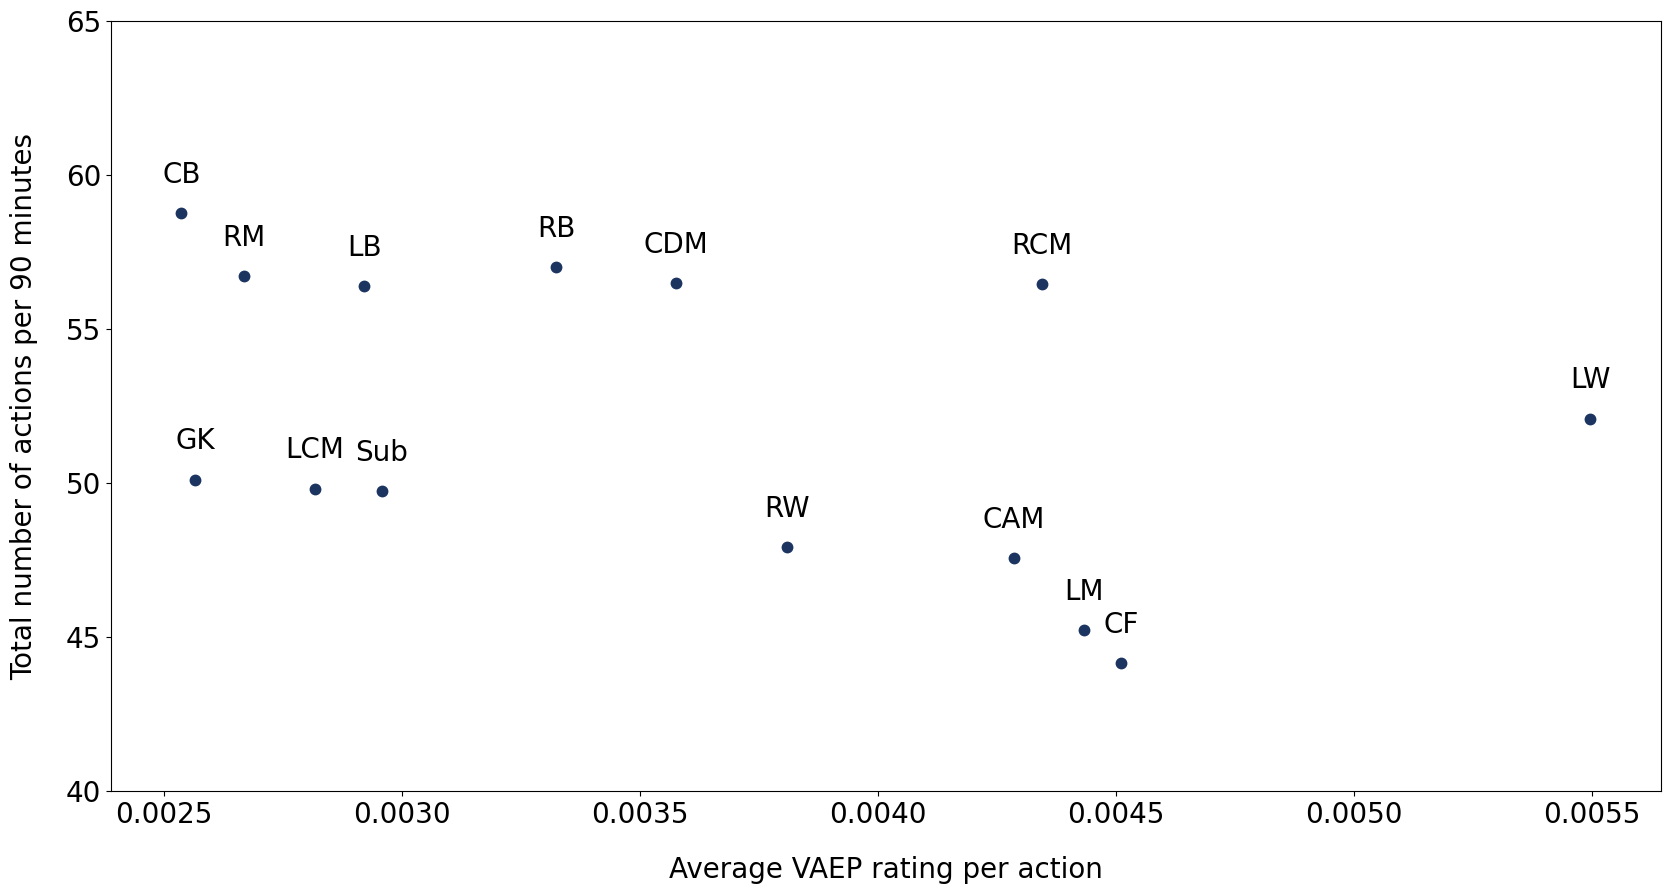

In [ ]:
# Analyzing Quantity vs Quality
positions_ranks = positions_ranks.sort_values('vaep_per_match', ascending=False)
plt.figure(figsize=(20, 10))
x = list(positions_ranks['vaep_mean'])
y = list(positions_ranks['actions_per_match'])
plt.plot(x, y, '.', c='#1C3460', markersize=15)

names = positions_ranks.index.values.tolist()
for i, txt in enumerate(names):
    plt.annotate(txt, (x[i], y[i] + 1), fontsize=20, horizontalalignment='center')


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.xlim(0.002, 0.005)
plt.ylim(40, 65)
plt.xlabel('Average VAEP rating per action', labelpad=20, fontsize=20)
plt.ylabel('Total number of actions per 90 minutes', labelpad=20, fontsize=20)
plt.show()

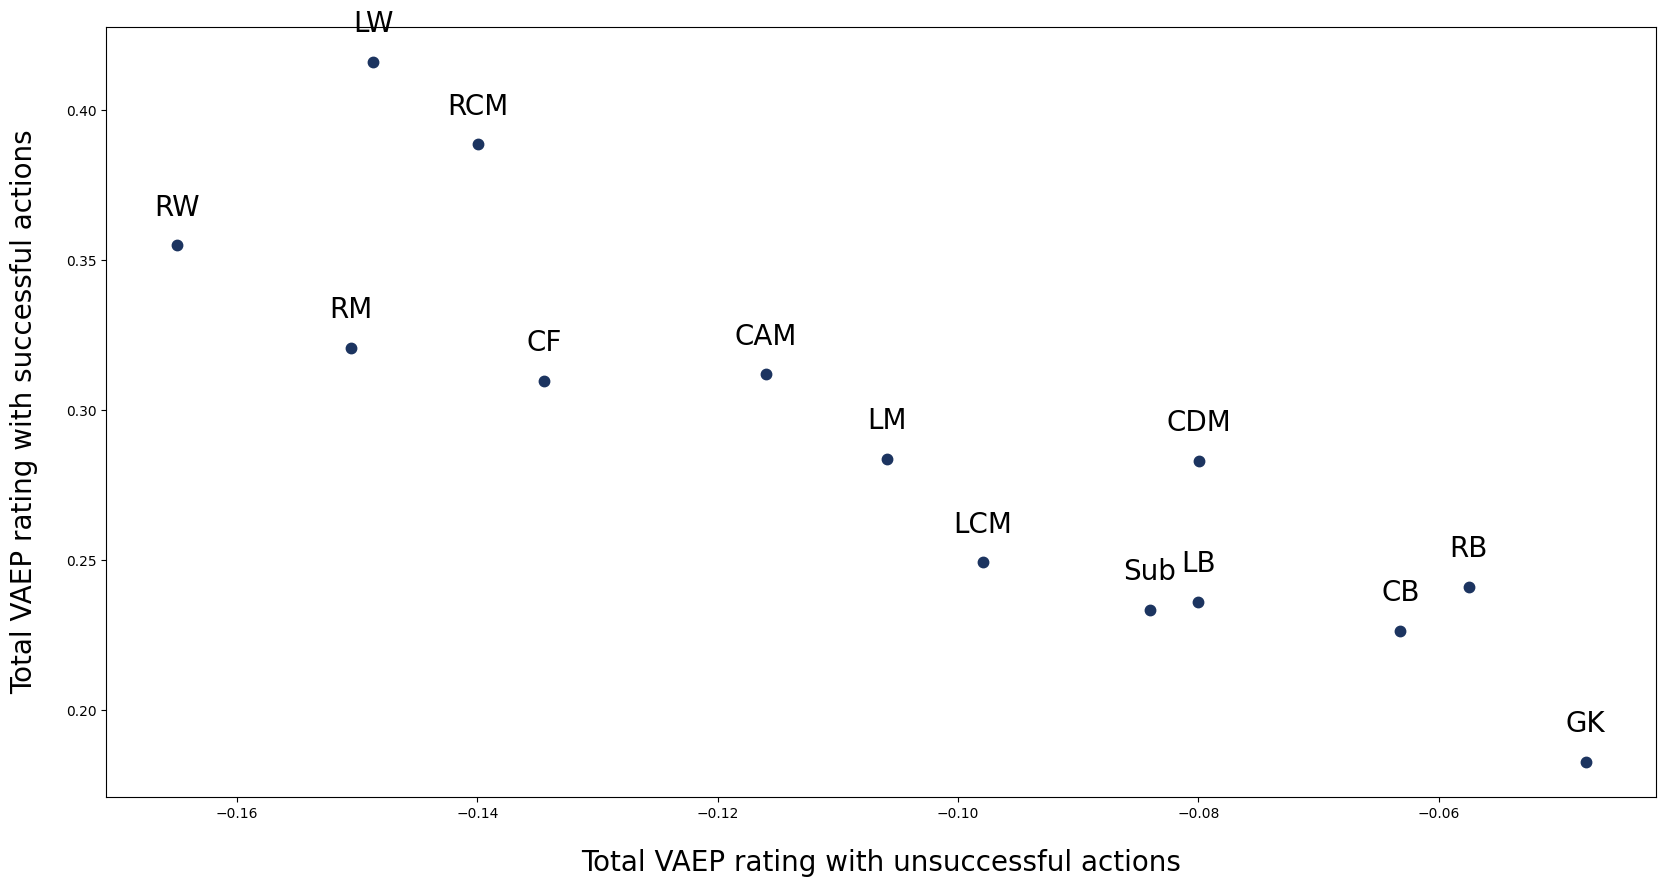

In [ ]:
# Analyzing Risk taken by position
positions_ranks = positions_ranks.sort_values('vaep_per_match', ascending=False)
plt.figure(figsize=(20, 10))
x = list(positions_ranks['fail'])
y = list(positions_ranks['success'])
plt.plot(x, y, '.', c='#1C3460', markersize=15)

names = positions_ranks.index.values.tolist()
for i, txt in enumerate(names):
    plt.annotate(txt, (x[i], y[i]+ 0.01), fontsize=20, horizontalalignment='center')

plt.xlabel('Total VAEP rating with unsuccessful actions', labelpad=20, fontsize=20)
plt.ylabel('Total VAEP rating with successful actions', labelpad=20, fontsize=20)
plt.show()

In [ ]:
# Getting Best 3 position by Club
positions_ranks_by_club = players_ratings.groupby(['team_name','position']).mean().sort_values(['team_name', 'vaep_per_match'], ascending=[True, False])
positions_ranks_by_club.groupby(level=0).head(3)

<ipython-input-88-290b12a981b2>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  positions_ranks_by_club = players_ratings.groupby(['team_name','position']).mean().sort_values(['team_name', 'vaep_per_match'], ascending=[True, False])


player_id   vaep_count   vaep_sum  \
team_name                    position                                          
1. FC Köln                   LB         18669.000000  1459.000000   4.333903   
                             LW         15543.000000   410.000000   1.963709   
                             LM         15039.000000   703.000000   1.866811   
1. FSV Mainz 05              RB         15399.000000  1897.000000   8.010680   
                             LB         21469.000000  1450.000000   6.186145   
                             Sub       224896.000000   576.000000   2.366612   
BV Borussia 09 Dortmund      CAM        14816.000000   914.000000   5.038178   
                             LW         22635.333333   533.333333   3.450192   
                             CDM       236895.750000  1048.750000   3.869900   
Borussia VfL Mönchengladbach LW         37822.500000  1052.000000   4.941393   
                             LCM       404219.000000   939.000000   4.164618   
                             CB         89108.333333  2296.000000   7.032671   
Eintracht Frankfurt          LM         69616.000000   867.000000   6.600252   
                             RCM       224680.000000  1459.000000   8.509670   
                             RB         15139.000000  1162.000000   5.976979   
FC Augsburg                  CDM       185387.000000  1176.000000   3.593850   
                             CAM        40480.500000  1081.500000   6.034244   
                             CF         37948.000000   720.000000   4.343073   
FC Bayern München            RW         14727.000000  1209.000000   9.320459   
                             LW         42411.000000  1468.000000   7.438491   
                             CAM        14732.000000  1237.000000   8.476034   
FC Schalke 04                RM         14989.000000  2405.000000  14.197515   
                             LW        105378.000000   841.000000   4.556465   
                             CDM       253651.000000  1201.000000   5.907781   
Hamburger SV                 CAM        14706.000000  1532.000000   6.901735   
                             CDM        91487.000000   850.600000   2.888233   
                             CF         15877.000000   594.000000   2.369511   
Hannover 96                  LW        149448.666667   989.000000   6.647950   
                             RB         75246.500000   762.000000   4.425947   
                             GK        149274.500000  1904.500000   5.360872   
Hertha BSC                   RW         15141.000000   322.000000   1.979314   
                             LW         11462.000000  1039.000000   6.295764   
                             LB         15125.000000  2103.000000   7.792599   
Rasen Ballsport Leipzig      RCM       231478.000000   563.500000   2.401258   
                             CDM        16110.000000  1601.000000   7.660721   
                             Sub        65596.000000  1236.000000   6.692339   
SC Freiburg                  CDM        25871.000000   299.000000   2.614489   
                             LB         14734.000000   822.000000   7.989036   
                             CAM        49982.000000   470.000000   2.411576   
SV Werder Bremen             RM         65055.000000  1088.000000   5.982439   
                             CF         16025.000000  1636.000000   7.444740   
                             LM         16027.000000   593.000000   2.850931   
TSG 1899 Hoffenheim          Sub        92197.000000   975.000000   7.361695   
                             RW         15292.000000   887.000000   8.438780   
                             LW        177862.500000  1096.000000   3.609453   
TSV Bayer 04 Leverkusen      LW         80907.000000  1402.000000  10.841156   
                             CB        161654.750000  1595.000000   6.938624   
                             RB        212604.000000   453.000000   1.468572   
VfB Stuttgart 1893           CDM       1714